<a href="https://colab.research.google.com/github/DarkDevil1306/DCU-Net/blob/main/Columbia_DCUNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**DCU-Net: a dual-channel U-shaped network for image splicing forgery detection**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path ='/content/drive/MyDrive/COLUMBIA/4cam_splc'
mask_path='/content/drive/MyDrive/COLUMBIA/4cam_splc/edgemask'


#####**TRAINING OF THE DATASETS**

### VGG16 Model

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Activation

def conv_block(input_tensor, filters, kernel_size=(3, 3), activation='relu', padding='same', block_name='block'):
    x = Conv2D(filters, kernel_size, padding=padding, name=f'conv_{block_name}')(input_tensor)
    x = BatchNormalization(name=f'bn_{block_name}')(x)
    x = Activation(activation, name=f'act_{block_name}')(x)
    return x

def maxpool_block(input_tensor, pool_size=(2, 2), strides=(2, 2), block_name='block'):
    return MaxPool2D(pool_size=pool_size, strides=strides, name=f'maxpool_{block_name}')(input_tensor)

skip_tensor = []

def vgg16_model(inputs, classes=100):

    # Block 1
    x = conv_block(inputs, 64, block_name='1_1')
    x = conv_block(x, 64, block_name='1_2')
    x = maxpool_block(x, block_name='1')
    skip_tensor.append(x)

    # Block 2
    x = conv_block(x, 128, block_name='2_1')
    x = conv_block(x, 128, block_name='2_2')
    x = maxpool_block(x, block_name='2')
    skip_tensor.append(x)

    # Block 3
    x = conv_block(x, 256, block_name='3_1')
    x = conv_block(x, 256, block_name='3_2')
    x = conv_block(x, 256, block_name='3_3')
    x = maxpool_block(x, block_name='3')
    skip_tensor.append(x)

    # Block 4
    x = conv_block(x, 512, block_name='4_1')
    x = conv_block(x, 512, block_name='4_2')
    x = conv_block(x, 512, block_name='4_3')
    x = maxpool_block(x, block_name='4')
    skip_tensor.append(x)

    # Block 5
    x = conv_block(x, 512, block_name='5_1')
    x = conv_block(x, 512, block_name='5_2')
    x = conv_block(x, 512, block_name='5_3')
    x = maxpool_block(x, block_name='5')

    print("vgg16: ",x.shape)

    return x;

### ResNet50 Model

In [ ]:
import tensorflow as tf
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add
from keras.models import Model

def residual_block(x, filters, stride=1):
    # Shortcut
    shortcut = x

    # First layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second layer
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    # Adding the shortcut after the second layer
    if stride != 1:
        # If stride is not 1, adjust the dimension of the shortcut before adding
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=(stride, stride), padding='same')(shortcut)
    x = Add()([x, shortcut])

    # Final ReLU
    x = ReLU()(x)
    return x

def create_resnet(inputs, num_blocks_list=[2, 2, 2, 2, 2]):
    # Initial conv layer
    x = Conv2D(8, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Creating the subsequent residual blocks
    num_filters = 8
    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            stride = 2 if j == 0 and i != 0 else 1  # Apply stride only for the first block in each group except the very first one
            x = residual_block(x, num_filters, stride)
        num_filters *= 2  # Double the number of filters at each new group of blocks

    # Create model
    print("resnet: ",x.shape)
    return x;


### Feature Fusion

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, Activation
from keras.layers import Concatenate, Input, UpSampling2D, AveragePooling2D

def dilated_conv_block(input_tensor, num_filters, dilation_rate, kernel_size=3, activation='relu', padding='same'):
    """Dilated convolutional block with activation."""
    x = Conv2D(num_filters, kernel_size, padding=padding, dilation_rate=dilation_rate)(input_tensor)
    x = Activation(activation)(x)
    return x

# vgg_output = vgg_model.output
# resnet_output = resnet_model.output
# resnet50_pooled = AveragePooling2D(pool_size=(2, 2))(resnet_output)

def feature_fusion(vgg_output, resnet50_pooled):
    # First fusion of the deep features from the two channels
    fused = Concatenate()([vgg_output, resnet50_pooled])

    # Multi-scale dilated convolution fusion
    dilated_1 = dilated_conv_block(fused, 256, dilation_rate=1)
    dilated_2 = dilated_conv_block(fused, 256, dilation_rate=2)
    dilated_3 = dilated_conv_block(fused, 256, dilation_rate=3)

    # Second fusion after multi-scale dilated convolution
    fused_dilated = Concatenate()([dilated_1, dilated_2, dilated_3])
    fused_dilated = UpSampling2D(size=(2, 2))(fused_dilated)
    print("feature fusion: ",fused_dilated.shape)

    return fused_dilated;

# Build the model using the outputs of the VGG16 and ResNet models
# fusion_model_output = feature_fusion(vgg_output, resnet_output)


### Feature Decoder

In [ ]:
from keras.layers import Conv2D, UpSampling2D, Concatenate
from keras.layers import Input, Conv2D, BatchNormalization, Activation, ZeroPadding2D
from keras.models import Model

def upsample_concat_block(input_tensor, skip_tensor, filters, block_name='block'):
    concat = Concatenate(name=f'concat_{block_name}')([input_tensor, skip_tensor])
    conv = conv_block(concat, filters, block_name=f'{block_name}_1')
    up = UpSampling2D(size=(2, 2), name=f'upsample_{block_name}')(conv)
    return up

# decoder_input = fusion_model_output

def feature_decoder(decoder_input):
  x = upsample_concat_block(decoder_input, skip_tensor[-1], 512, block_name='6')
  x = upsample_concat_block(x, skip_tensor[-2], 256, block_name='7')
  x = upsample_concat_block(x, skip_tensor[-3], 128, block_name='8')
  x = upsample_concat_block(x, skip_tensor[-4], 64, block_name='9')
  x = Conv2D(64, (3, 3), padding='same')(x)
  x = Conv2D(1, (1, 1))(x)
  print("feature decoder before zeropadding: ",x.shape)
  # x = ZeroPadding2D(padding=(1, 1))(x)
  x = BatchNormalization()(x)
  x = Activation('sigmoid')(x)
  return x;

In [ ]:
import tensorflow as tf

def apply_gaussian_blur_tf(inputs, kernel_size=(5, 5), sigma=0):
    # Convert the input tensor to float32
    inputs = tf.cast(inputs, tf.float32)

    # Create a Gaussian blur filter
    filter_weights = tf.constant([[1, 4, 6, 4, 1],
                                  [4, 16, 24, 16, 4],
                                  [6, 24, 36, 24, 6],
                                  [4, 16, 24, 16, 4],
                                  [1, 4, 6, 4, 1]], dtype=tf.float32) / 256.0
    filter_weights = tf.reshape(filter_weights, (*kernel_size, 1, 1))
    filter_weights = tf.tile(filter_weights, [1, 1, tf.shape(inputs)[-1], 1])

    # Apply depthwise convolution
    blurred = tf.nn.depthwise_conv2d(inputs, filter_weights, strides=[1, 1, 1, 1], padding='SAME')

    # Subtract the blurred image from the original to get the residual
    residual = tf.subtract(inputs, blurred)

    return residual


In [ ]:
def dcunet(input_shape):
  inputs=Input(input_shape)
  normal_image=inputs
  residual_image=apply_gaussian_blur_tf(inputs)
  vgg_output=vgg16_model(normal_image)
  resnet_output=create_resnet(residual_image)
  resnet50_pooled = AveragePooling2D(pool_size=(2, 2))(resnet_output)
  fusion_model_output = feature_fusion(vgg_output, resnet50_pooled)
  output=feature_decoder(fusion_model_output)
  print("final output :",output.shape)
  return Model(inputs,output)

In [ ]:
dcunet(input_shape=(256,256,3))

vgg16:  (None, 8, 8, 512)
resnet:  (None, 16, 16, 128)
feature fusion:  (None, 16, 16, 768)
feature decoder before zeropadding:  (None, 256, 256, 1)
final output : (None, 256, 256, 1)


In [ ]:
import os

spliced_images = [file for file in os.listdir(dataset_path) if file.endswith('tif')]
mask_images=[file for file in os.listdir(mask_path) if file.endswith('edgemask.jpg')]
print(spliced_images)
print(mask_images)

['canong3_nikond70_sub_01.tif', 'canong3_nikond70_sub_02.tif', 'canong3_nikond70_sub_03.tif', 'canong3_nikond70_sub_04.tif', 'canong3_nikond70_sub_05.tif', 'canong3_nikond70_sub_06.tif', 'canong3_nikond70_sub_07.tif', 'canong3_nikond70_sub_08.tif', 'canong3_nikond70_sub_09.tif', 'canong3_nikond70_sub_10.tif', 'canong3_nikond70_sub_11.tif', 'canong3_nikond70_sub_12.tif', 'canong3_nikond70_sub_13.tif', 'canong3_nikond70_sub_14.tif', 'canong3_nikond70_sub_15.tif', 'canong3_nikond70_sub_16.tif', 'canong3_nikond70_sub_17.tif', 'canong3_nikond70_sub_18.tif', 'canong3_nikond70_sub_19.tif', 'canong3_nikond70_sub_20.tif', 'canong3_nikond70_sub_21.tif', 'canong3_nikond70_sub_22.tif', 'canong3_nikond70_sub_23.tif', 'canong3_nikond70_sub_24.tif', 'canong3_nikond70_sub_25.tif', 'canong3_nikond70_sub_26.tif', 'canong3_nikond70_sub_27.tif', 'canong3_nikond70_sub_28.tif', 'canong3_nikond70_sub_29.tif', 'canong3_nikond70_sub_30.tif', 'canong3_canonxt_sub_01.tif', 'canong3_canonxt_sub_02.tif', 'canong3_

In [ ]:
import os
from sklearn.model_selection import train_test_split

# Define the ratio for splitting (e.g., 1622 for training, 180 for testing)
train_size = 85
test_size = 5

# Step 1: Split all_images into training and test sets
spliced_train, spliced_test = train_test_split(spliced_images, train_size=train_size, test_size=test_size, random_state=42)

# Step 2: Process training data
auth_train = []
filtered_spliced_train = []

for filename in spliced_train:
    base_filename = os.path.splitext(os.path.basename(filename))[0]
    matching_groundtruth = next((gt for gt in mask_images if os.path.splitext(os.path.basename(gt))[0].replace('_edgemask', '') == base_filename), None)

    if matching_groundtruth:
        auth_train.append(matching_groundtruth)
        filtered_spliced_train.append(filename)

# Update all_images_train with filtered list
all_images_train = filtered_spliced_train

# Step 3: Process test data
auth_test = []
filtered_spliced_test = []

for filename in spliced_test:
    base_filename = os.path.splitext(os.path.basename(filename))[0]
    matching_groundtruth = next((gt for gt in mask_images if os.path.splitext(os.path.basename(gt))[0].replace('_edgemask', '') == base_filename), None)

    if matching_groundtruth:
        auth_test.append(matching_groundtruth)
        filtered_spliced_test.append(filename)

# Update all_images_test with filtered list
all_images_test = filtered_spliced_test

# Now you have separate lists for training and test data along with their respective filenames
print("Training Data:")
print("Number of All Images (Training):", len(all_images_train))
print("Number of Groundtruth Images (Training):", len(auth_train))
print("All Images:", all_images_train)
print("Groundtruth Images:", auth_train)

print("\nTest Data:")
print("Number of All Images (Test):", len(all_images_test))
print("Number of Groundtruth Images (Test):", len(auth_test))
print("All Images:", all_images_test)
print("Groundtruth Images:", auth_test)

Training Data:
Number of All Images (Training): 85
Number of Groundtruth Images (Training): 85
All Images: ['canong3_nikond70_sub_16.tif', 'canong3_nikond70_sub_25.tif', 'canong3_kodakdcs330_sub_09.tif', 'nikond70_canonxt_sub_24.tif', 'nikond70_canonxt_sub_29.tif', 'nikond70_canonxt_sub_04.tif', 'canonxt_kodakdcs330_sub_10.tif', 'canong3_kodakdcs330_sub_10.tif', 'nikond70_kodakdcs330_sub_23.tif', 'canong3_canonxt_sub_16.tif', 'canong3_nikond70_sub_17.tif', 'canong3_canonxt_sub_22.tif', 'nikond70_kodakdcs330_sub_06.tif', 'nikond70_canonxt_sub_07.tif', 'canong3_canonxt_sub_27.tif', 'nikond70_canonxt_sub_08.tif', 'nikond70_kodakdcs330_sub_01.tif', 'nikond70_kodakdcs330_sub_24.tif', 'canong3_canonxt_sub_01.tif', 'canong3_nikond70_sub_10.tif', 'canonxt_kodakdcs330_sub_23.tif', 'canong3_kodakdcs330_sub_01.tif', 'canong3_nikond70_sub_19.tif', 'nikond70_kodakdcs330_sub_29.tif', 'canonxt_kodakdcs330_sub_24.tif', 'nikond70_canonxt_sub_20.tif', 'canong3_canonxt_sub_26.tif', 'nikond70_kodakdcs330_

<ipython-input-27-44d0b6c83772>:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  edgemask = edgemask.resize((512, 512), Image.ANTIALIAS)  # Resize to 512*512


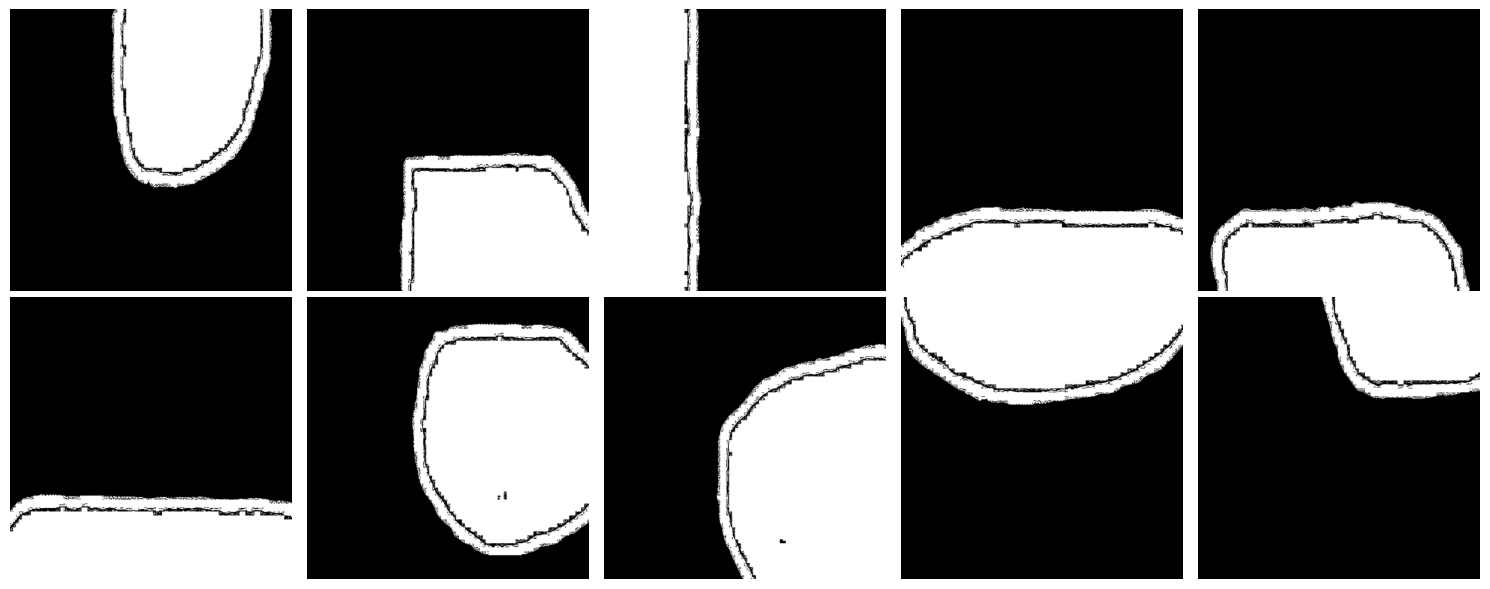

In [ ]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

def convert_colors(edgemask):
    # Identify pixels with green values of 255 and 200
    green_255_pixels = (edgemask[:, :, 1] == 255)
    green_200_pixels = (edgemask[:, :, 1] == 200)

    # Set pixels with green values of 255 and 200 to white
    edgemask[green_255_pixels | green_200_pixels] = [255, 255, 255]

    # Set the rest of the pixels to black
    edgemask[~(green_255_pixels | green_200_pixels)] = [0, 0, 0]

    return edgemask


fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    image_path = os.path.join(mask_path, mask_images[i])
    image = Image.open(image_path)

    # Convert colors
    edgemask_array = np.array(image)
    edgemask_array = convert_colors(edgemask_array)

    # Convert to black and white using a threshold
    threshold = 127  # You can adjust the threshold as needed
    edgemask_array = np.mean(edgemask_array, axis=-1) > threshold

    edgemask = Image.fromarray((edgemask_array * 255).astype(np.uint8), mode='L')

    edgemask = edgemask.resize((512, 512), Image.ANTIALIAS)  # Resize to 512*512

    ax.imshow(edgemask, cmap='gray')  # Display using a grayscale colormap
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
from PIL import Image

def load_images(image_paths, root_path, target_size=(256, 256), is_ground_truth=False):
    images = []
    for image_name in image_paths:
        image_path = os.path.join(root_path, image_name)
        image = Image.open(image_path)
        image = image.resize(target_size, Image.LANCZOS)

        # Convert to grayscale (single channel) only for ground truth
        if is_ground_truth:
            # Threshold the pixel values to 0 or 1
            image_array = np.array(image)
            image_array = convert_colors(image_array)
            # Convert to black and white using a threshold
            threshold = 127  # You can adjust the threshold as needed
            image_array = np.mean(image_array, axis=-1) > threshold
            image_array = Image.fromarray((image_array * 255).astype(np.uint8), mode='L')
            image = np.array(image_array) / 255.0  # Normalize pixel values to the range [0, 1]
            image_array = np.where(image > 0.5, 1.0, 0.0)  # Thresholding
            image_array = np.expand_dims(image_array, axis=-1)  # Expand dimensions for single-channel images
        else:
            image_array = np.array(image) / 255.0  # Normalize pixel values to the range [0, 1]

        images.append(image_array)

    return np.array(images)

# Load training images and groundtruth images
x_train = load_images(all_images_train, dataset_path)
y_train = load_images(auth_train, mask_path, is_ground_truth=True)

# Load test images and groundtruth images without conversion
x_test = load_images(all_images_test, dataset_path)
y_test = load_images(auth_test, mask_path, is_ground_truth=True)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(85, 256, 256, 3) (85, 256, 256, 1)
(5, 256, 256, 3) (5, 256, 256, 1)


In [ ]:
import numpy as np
from scipy import ndimage

# Assuming x_train and y_train are lists of numpy arrays representing images and masks

# Function to perform image augmentation
def augment_images(images, masks):
    augmented_images = []
    augmented_masks = []

    for image, mask in zip(images, masks):
        # Rotate the original image and mask
        augmented_images.append(image)
        augmented_masks.append(mask)

        # Rotate by 90 degrees
        rotated_image = np.rot90(image, k=1, axes=(0, 1))
        rotated_mask = np.rot90(mask, k=1, axes=(0, 1))
        augmented_images.append(rotated_image)
        augmented_masks.append(rotated_mask)

        # Rotate by 180 degrees
        rotated_image = np.rot90(image, k=2, axes=(0, 1))
        rotated_mask = np.rot90(mask, k=2, axes=(0, 1))
        augmented_images.append(rotated_image)
        augmented_masks.append(rotated_mask)

        # Rotate by 270 degrees
        rotated_image = np.rot90(image, k=3, axes=(0, 1))
        rotated_mask = np.rot90(mask, k=3, axes=(0, 1))
        augmented_images.append(rotated_image)
        augmented_masks.append(rotated_mask)

    return np.array(augmented_images), np.array(augmented_masks)

# Apply augmentation
x_train, y_train = augment_images(x_train, y_train)
x_test, y_test=augment_images(x_test, y_test)

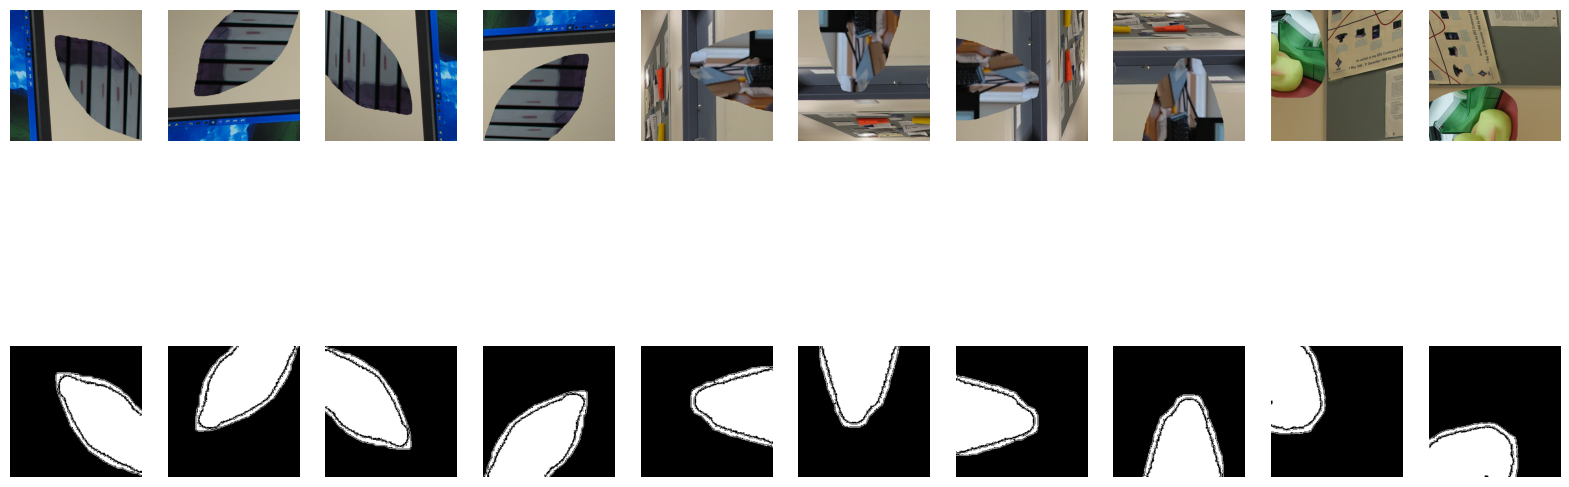

In [ ]:
import matplotlib.pyplot as plt

# Assuming x_train and y_train are lists of numpy arrays representing images and masks

# Function to plot images with masks
def plot_images(images, masks, num_images=10, figsize=(20, 8)):
    fig, axes = plt.subplots(2, num_images, figsize=figsize)

    for i in range(num_images):
        ax1 = axes[0, i]
        ax2 = axes[1, i]

        # Display image
        ax1.imshow(images[i])
        ax1.axis('off')

        # Display mask
        ax2.imshow(masks[i], cmap='gray')  # Assuming masks are black and white
        ax2.axis('off')

    plt.show()

# Plot 10 images with masks in a larger figure size
plot_images(x_train, y_train, num_images=10, figsize=(20, 8))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

# Custom Weighted Binary Cross-Entropy Loss Function
def weighted_binary_cross_entropy(y_true, y_pred):
    pos_weight=2.0
    # Calculate the weighted binary cross entropy loss
    loss = -tf.reduce_mean(pos_weight * y_true * tf.math.log(y_pred + 1e-7) +
                           (1 - y_true) * tf.math.log(1 - y_pred + 1e-7))

    return loss

# Define the model based on the DCU-Net architecture
model = dcunet(input_shape=(256,256,3))

# Compile the model
optimizer = optimizers.Adam(learning_rate=0.0001,weight_decay=0.01)
model.compile(optimizer=optimizer, loss=weighted_binary_cross_entropy, metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),'accuracy'])

# Train-validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Define training parameters
epochs_stage1 = 100
epochs_stage2 = 200
batch_size = 16

vgg16:  (None, 8, 8, 512)
resnet:  (None, 16, 16, 128)
feature fusion:  (None, 16, 16, 768)
feature decoder before zeropadding:  (None, 256, 256, 1)
final output : (None, 256, 256, 1)


In [ ]:
history_stage1 = model.fit(x_train, y_train, epochs=epochs_stage1, batch_size=batch_size, validation_data=(x_val, y_val))

Epoch 1/100
17/17 [==============================] - 83s 1s/step - loss: 0.6982 - precision: 0.4245 - recall: 0.7643 - accuracy: 0.7090 - val_loss: 0.8179 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.7697
Epoch 2/100
17/17 [==============================] - 11s 652ms/step - loss: 0.5746 - precision: 0.5800 - recall: 0.9055 - accuracy: 0.8284 - val_loss: 0.8191 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.7697
Epoch 3/100
17/17 [==============================] - 11s 679ms/step - loss: 0.5465 - precision: 0.6342 - recall: 0.9229 - accuracy: 0.8606 - val_loss: 0.8171 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.7697
Epoch 4/100
17/17 [==============================] - 11s 676ms/step - loss: 0.5322 - precision: 0.6498 - recall: 0.9415 - accuracy: 0.8705 - val_loss: 0.8141 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.7697
Epoch 5/100
17/17 [==============================] - 11s 676ms/step

In [ ]:
model.optimizer.lr.assign(0.00001)  # Set learning rate for the second stage
history_stage2 = model.fit(x_train, y_train, epochs=epochs_stage2, batch_size=batch_size, validation_data=(x_val, y_val))

Epoch 1/200
17/17 [==============================] - 12s 695ms/step - loss: 0.3654 - precision: 0.9179 - recall: 0.9959 - accuracy: 0.9787 - val_loss: 0.4335 - val_precision: 0.8341 - val_recall: 0.9231 - val_accuracy: 0.9400
Epoch 2/200
17/17 [==============================] - 11s 680ms/step - loss: 0.3651 - precision: 0.9182 - recall: 0.9959 - accuracy: 0.9788 - val_loss: 0.4341 - val_precision: 0.8334 - val_recall: 0.9258 - val_accuracy: 0.9403
Epoch 3/200
17/17 [==============================] - 11s 651ms/step - loss: 0.3651 - precision: 0.9200 - recall: 0.9956 - accuracy: 0.9792 - val_loss: 0.4335 - val_precision: 0.8321 - val_recall: 0.9279 - val_accuracy: 0.9403
Epoch 4/200
17/17 [==============================] - 11s 679ms/step - loss: 0.3650 - precision: 0.9197 - recall: 0.9958 - accuracy: 0.9791 - val_loss: 0.4346 - val_precision: 0.8279 - val_recall: 0.9300 - val_accuracy: 0.9393
Epoch 5/200
17/17 [==============================] - 11s 679ms/step - loss: 0.3645 - precision: 

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Convert pixel values to binary labels based on a threshold
threshold = 0.5
binary_y_test = (y_test > threshold).astype(int)
binary_predictions = (model.predict(x_test) > threshold).astype(int)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(binary_y_test.flatten(), binary_predictions.flatten(), average='binary')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')

1/1 [==============================] - 13s 13s/step
Precision: 0.840690354386179
Recall: 0.9665664662658651
F1 Score: 0.8992447512464479


In [ ]:
from sklearn.metrics import accuracy_score

y_pred=model.predict(x_test)

threshold = 0.5  # Adjust the threshold based on your problem

# Convert probabilities to binary predictions based on the threshold
y_pred_threshold =  (y_pred > threshold).astype('uint8')

# Flatten the arrays for accuracy calculation
y_test_flat = y_test.flatten().astype('uint8')
y_pred_flat = y_pred_threshold.flatten()

# Calculate accuracy
accuracy = accuracy_score(y_test_flat, y_pred_flat)

print(f'Accuracy: {accuracy}')


1/1 [==============================] - 0s 41ms/step
Accuracy: 0.9505241394042969


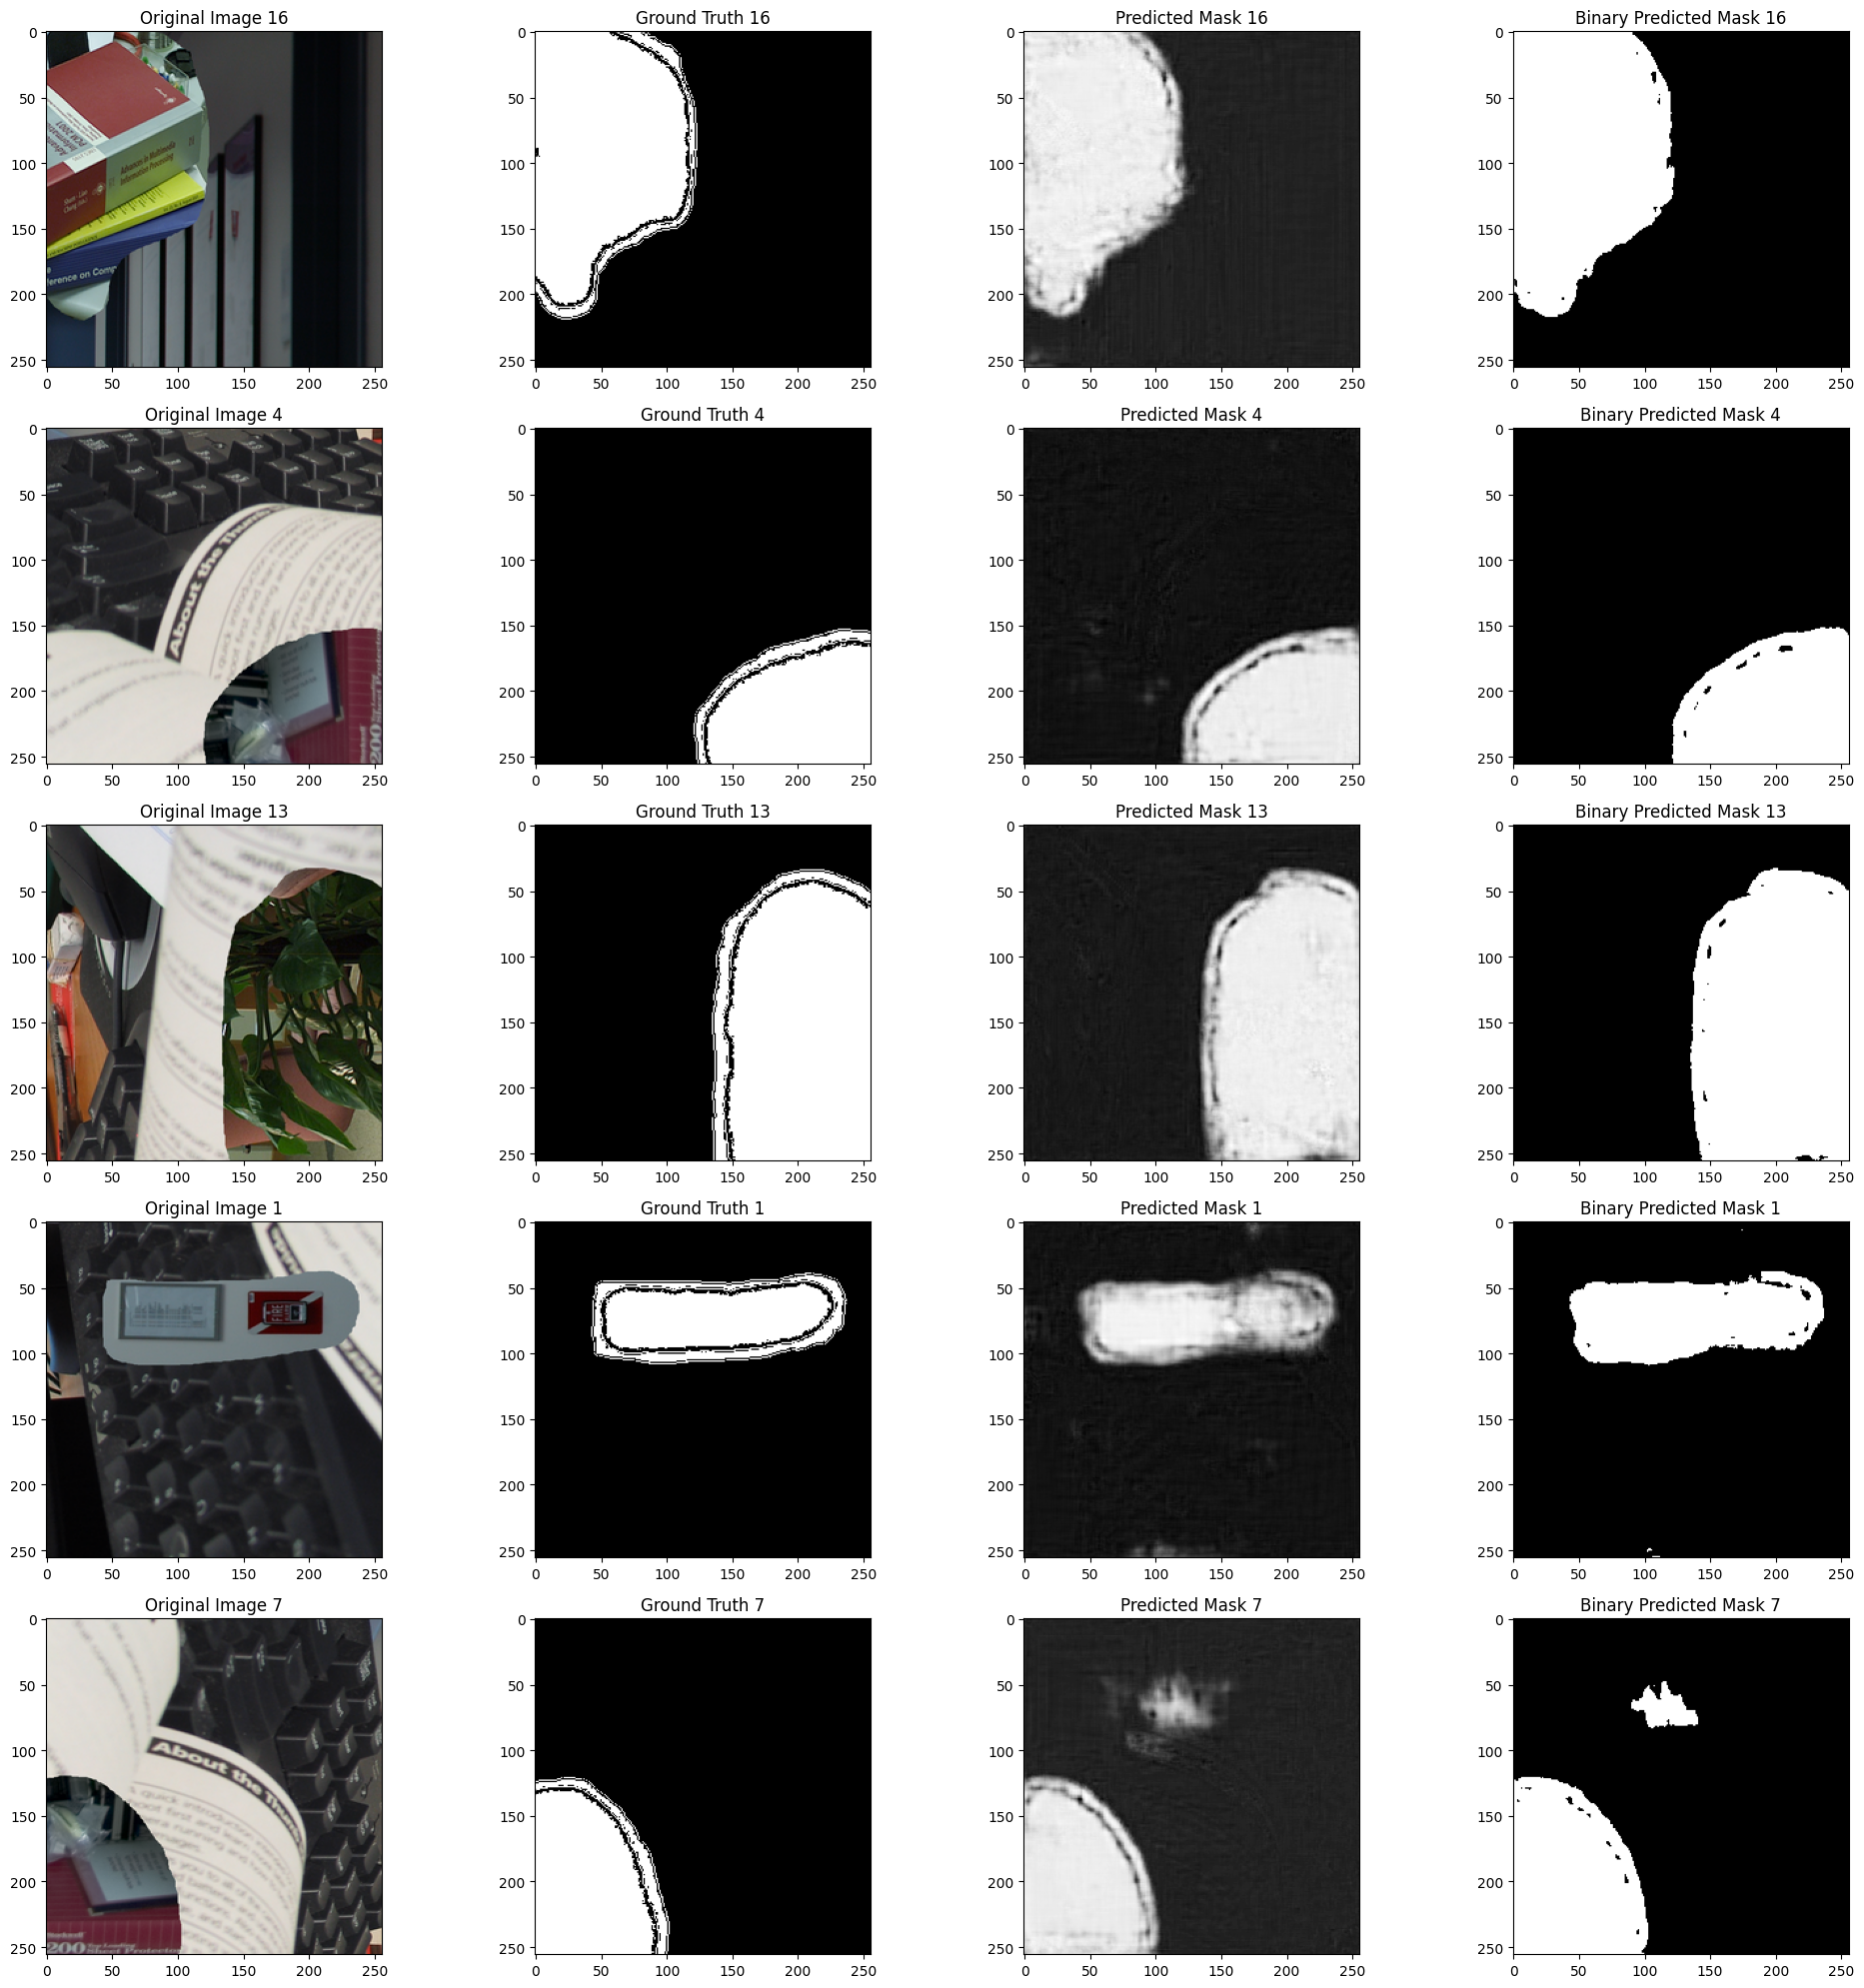

In [ ]:
import random

# Assuming x_test, y_test, and y_pred are your data
num_samples_to_show = 5
indices_random_5 = random.sample(range(len(x_test)), num_samples_to_show)

threshold = 0.5  # Adjust the threshold as needed

# Convert y_pred to binary masks using the threshold
y_pred_binary = (y_pred > threshold).astype('uint8')

# Set up the subplots
fig, axes = plt.subplots(num_samples_to_show, 4, figsize=(20, 20))

# Loop over the random indices
for i, idx in enumerate(indices_random_5):
    # Convert the images to uint8 for displaying
    original_image = (x_test[idx] * 255.0).astype('uint8')
    ground_truth = (y_test[idx] * 255.0).astype('uint8')
    predicted_mask = (y_pred[idx] * 255.0).astype('uint8')
    predicted_mask_binary = (y_pred_binary[idx] * 255.0).astype('uint8')

    # Display original image
    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title(f'Original Image {idx}')

    # Display ground truth
    axes[i, 1].imshow(ground_truth, cmap='gray')
    axes[i, 1].set_title(f'Ground Truth {idx}')

    # Display predicted mask (original)
    axes[i, 2].imshow(predicted_mask, cmap='gray')
    axes[i, 2].set_title(f'Predicted Mask {idx}')

    # Display predicted mask (binary)
    axes[i, 3].imshow(predicted_mask_binary, cmap='gray')
    axes[i, 3].set_title(f'Binary Predicted Mask {idx}')

plt.tight_layout()
plt.show()


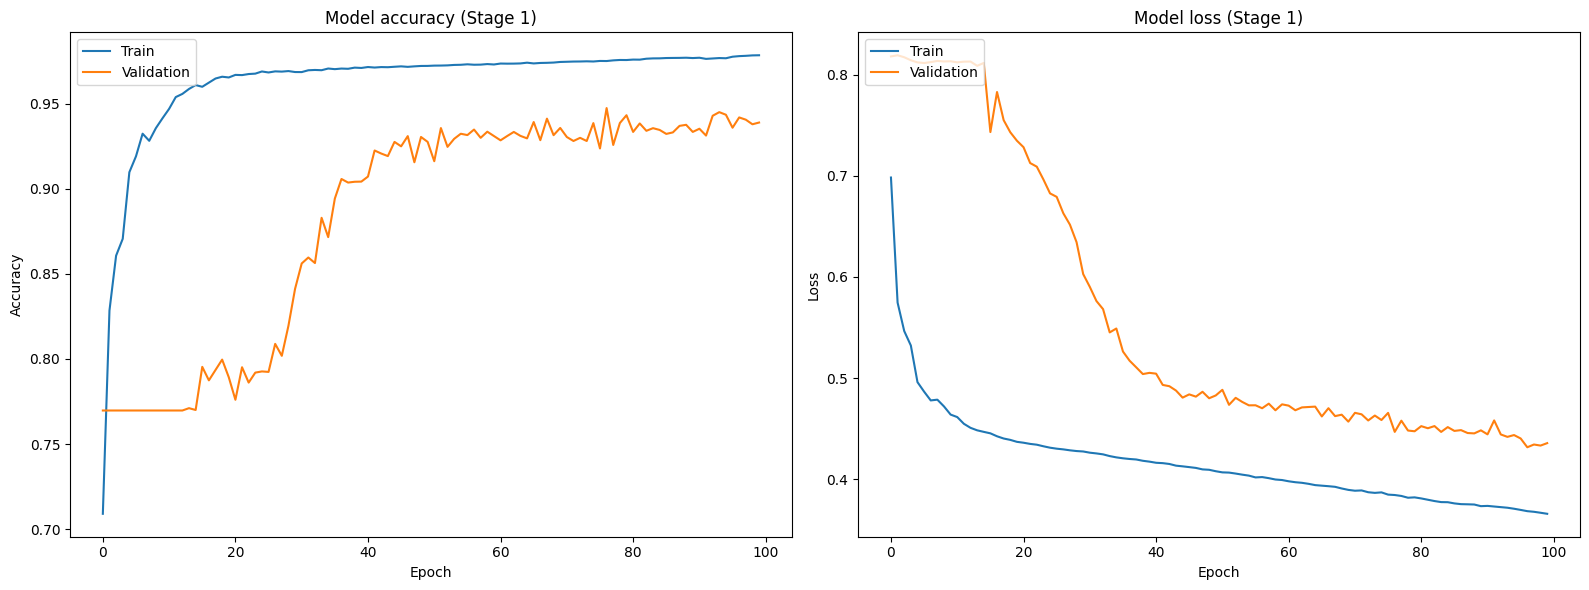

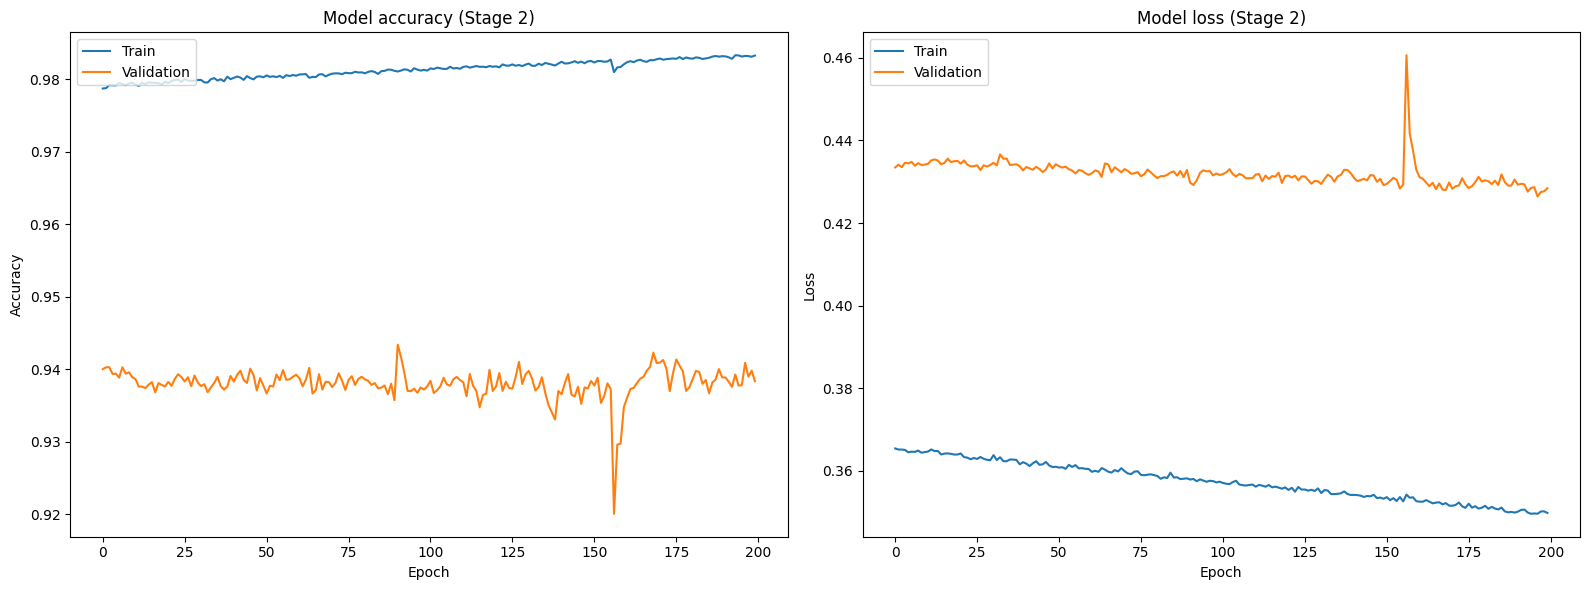

In [ ]:
# Plot both training histories side by side
plt.figure(figsize=(16, 6))

# Plot training accuracy values (Stage 1)
plt.subplot(1, 2, 1)
plt.plot(history_stage1.history['accuracy'])
plt.plot(history_stage1.history['val_accuracy'])
plt.title('Model accuracy (Stage 1)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training loss values (Stage 1)
plt.subplot(1, 2, 2)
plt.plot(history_stage1.history['loss'])
plt.plot(history_stage1.history['val_loss'])
plt.title('Model loss (Stage 1)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Plot both training histories side by side
plt.figure(figsize=(16, 6))

# Plot training accuracy values (Stage 2)
plt.subplot(1, 2, 1)
plt.plot(history_stage2.history['accuracy'])
plt.plot(history_stage2.history['val_accuracy'])
plt.title('Model accuracy (Stage 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training loss values (Stage 2)
plt.subplot(1, 2, 2)
plt.plot(history_stage2.history['loss'])
plt.plot(history_stage2.history['val_loss'])
plt.title('Model loss (Stage 2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()